## Modelling X-ray Function with Basis functions

I want a model for an X-ray spectrum that's flexible, because I don't care 
what the underlying process does.

Gaussian Processes don't work so well, because I need to put the model through 
a convolution before applying the likelihood.

So we're going to do a Gaussian basis function expansion instead.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import numpy as np
from scipy import stats
import scipy.special

import astropy.io.fits as fits
from astropy.modeling import models
from astropy.modeling.fitting import _fitter_to_model_params
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from clarsach import ARF, RMF


In [2]:
datadir = "/Users/danielahuppenkothen/work/repositories/clarsach/data/"

In [3]:
arf = ARF(datadir+"arfs/aciss_hetg0_cy19.arf")
rmf = RMF(datadir+"rmfs/aciss_hetg0_cy19.rmf")

Let's restrict the spectrum to low energies so that I don't have that many energy bins to worry about, and also so that I don't have to worry really low counts.

But for the creation of the data and the application of the ARF/RMF, I need the full array, so let's just define the maximum index for now and apply that later:

In [4]:
e_low = arf.e_low
e_high = arf.e_high

e_mid = e_low + (e_high - e_low)/2.0

In [5]:
max_ind = e_low.searchsorted(2.0)

In [6]:
pl_idx = 1.5
pl_norm = 1.0

In [7]:
true_pars = {"pl_idx": pl_idx, "pl_norm": pl_norm}

In [8]:
pl = models.PowerLaw1D(amplitude=pl_norm, alpha=pl_idx)
pl.x_0.fixed=True

In [9]:
pl_mod = pl(e_mid)

<IPython.core.display.Javascript object>


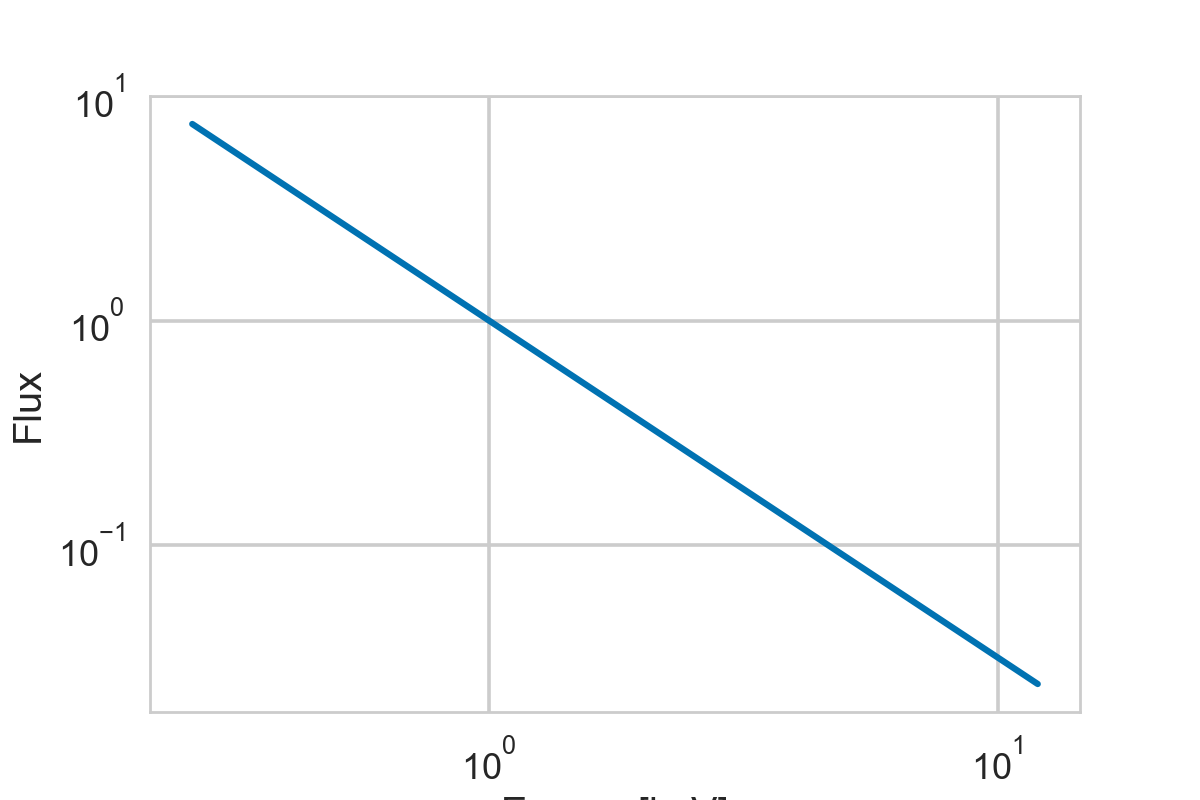

Text(0,0.5,'Flux')

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.loglog(e_mid, pl_mod)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux")

Let's also create a Gaussian so I can have a pretend spectral line:

In [11]:
gauss_amp = 1.0
mean = 1.0
stddev = 0.1

In [12]:
true_pars["gauss_amp"] = gauss_amp
true_pars["gauss_mean"] = mean
true_pars["gauss_std"] = stddev

In [13]:
gauss = models.Gaussian1D(amplitude=gauss_amp, mean=mean, stddev=stddev)

In [14]:
gauss_model = gauss(e_mid)

In [15]:
mm = pl_mod + gauss_model

<IPython.core.display.Javascript object>


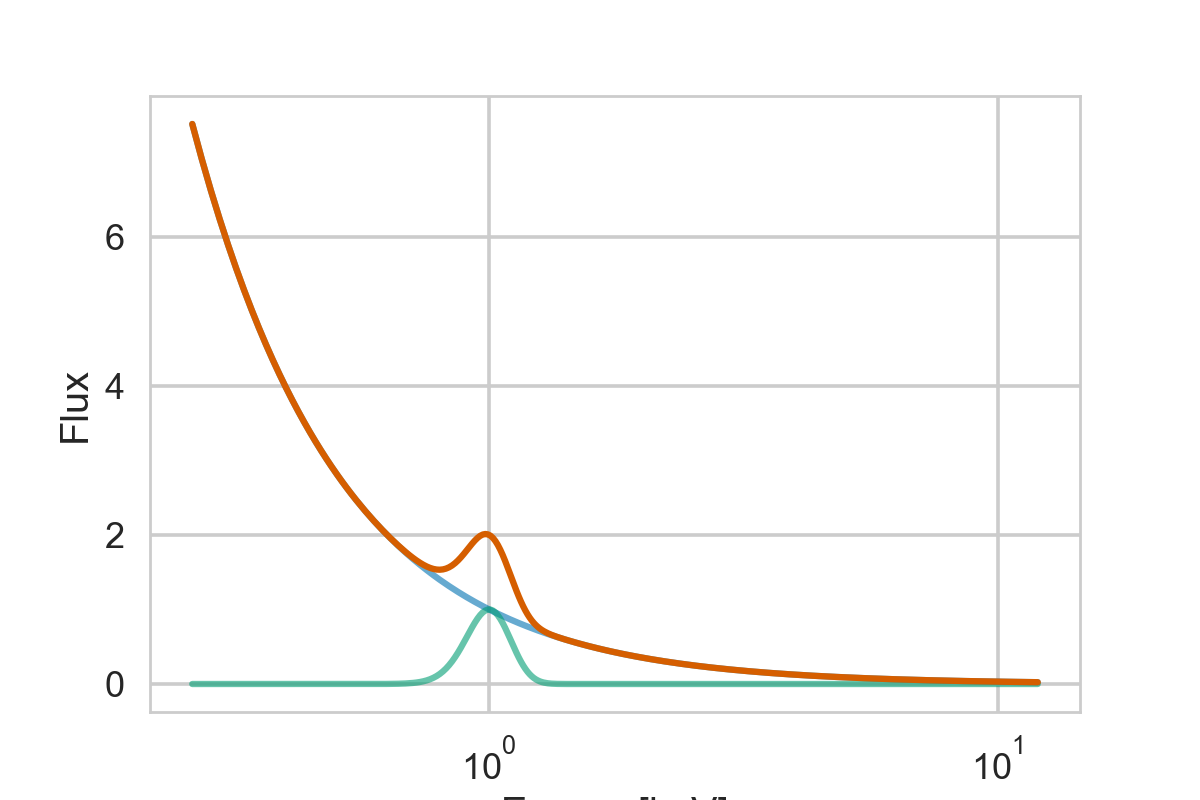

Text(0,0.5,'Flux')

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.semilogx(e_mid, pl_mod, alpha=0.6)
ax.semilogx(e_mid, gauss_model, alpha=0.6)
ax.semilogx(e_mid, mm)
ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux")

Okay, now we just need to add some stuff to the background to make it look less smooth. Let's do that via a Gaussian Process, just for fun:

In [201]:
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly-spaced Gaussian Features for 1D input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)


In [202]:
ngaussian = 10

In [203]:
width_factor = 0.5

In [204]:
true_pars["width_factor"] = width_factor

In [205]:
gf = GaussianFeatures(N=ngaussian, width_factor=width_factor)

In [206]:
gf.fit(e_mid[:,None])
gft = gf.transform(e_mid[:, None])

In [207]:
np.random.seed(100)

In [208]:
wtrue = np.random.normal(loc=0.8, scale=0.15, size=ngaussian)

In [209]:
true_pars["wtrue"] = wtrue

In [210]:
gbf_model = np.dot(gft, wtrue)

<IPython.core.display.Javascript object>


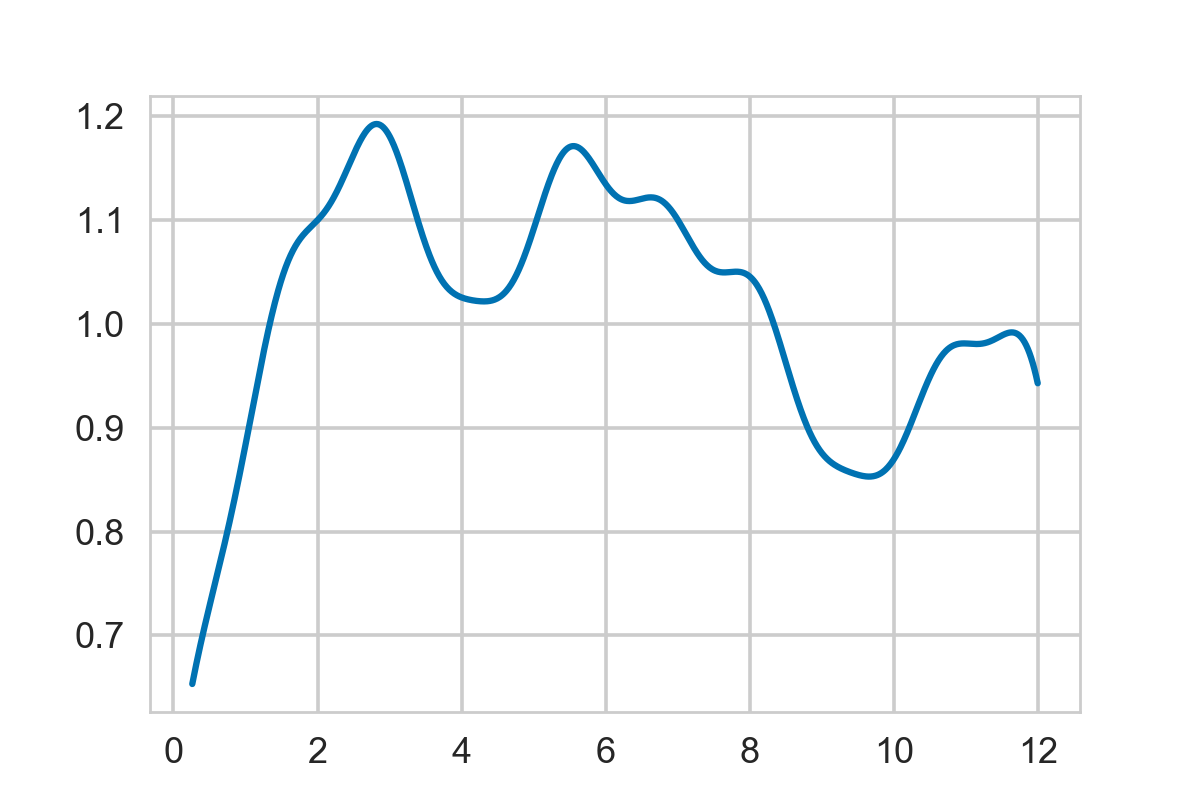

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(e_mid, gbf_model)

Awesome, now let's add that to the rest of our model:

In [212]:
bkg_model = pl_mod * gbf_model
source_model = mm * gbf_model

<IPython.core.display.Javascript object>


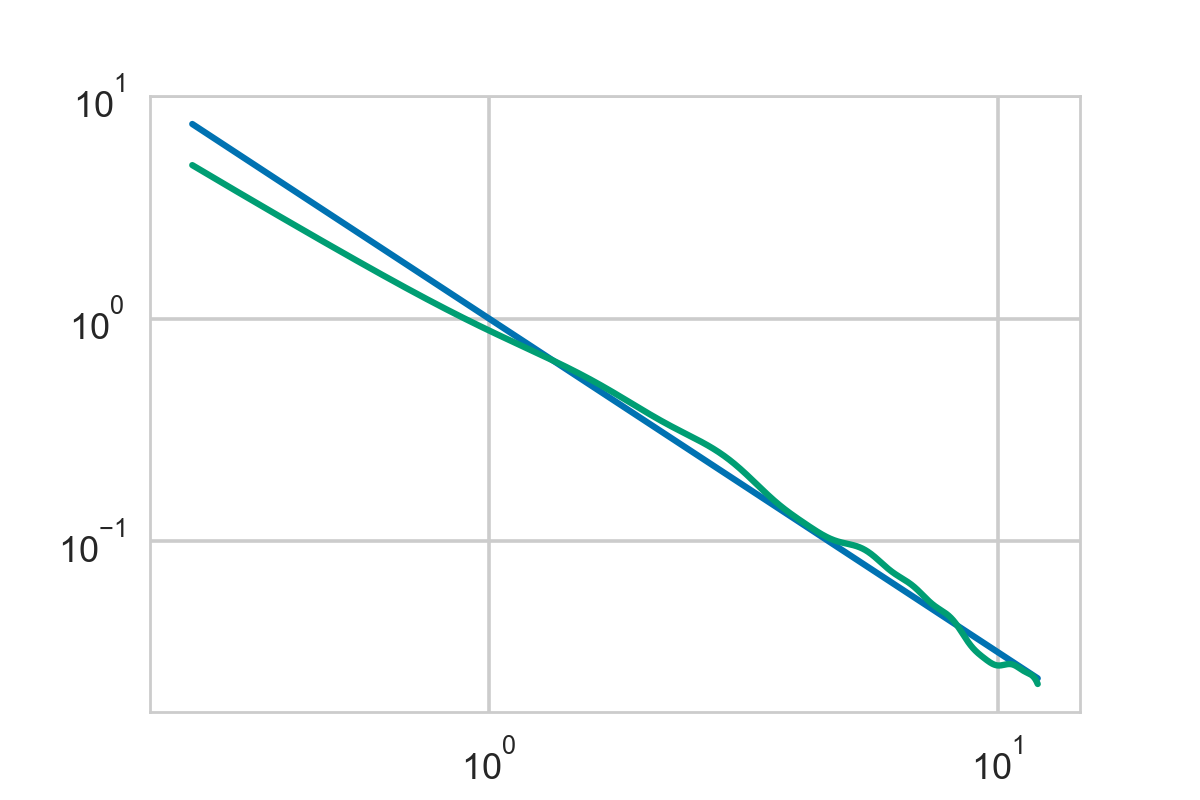

In [213]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(e_mid, pl_mod)
ax.plot(e_mid, bkg_model)
#ax.plot(e_mid, source_model)
ax.set_xscale('log')
ax.set_yscale('log')

The last thing we need to do is add Poisson noise:

In [214]:
bkg_data = np.random.poisson(bkg_model)
source_data = np.random.poisson(source_model)

<IPython.core.display.Javascript object>


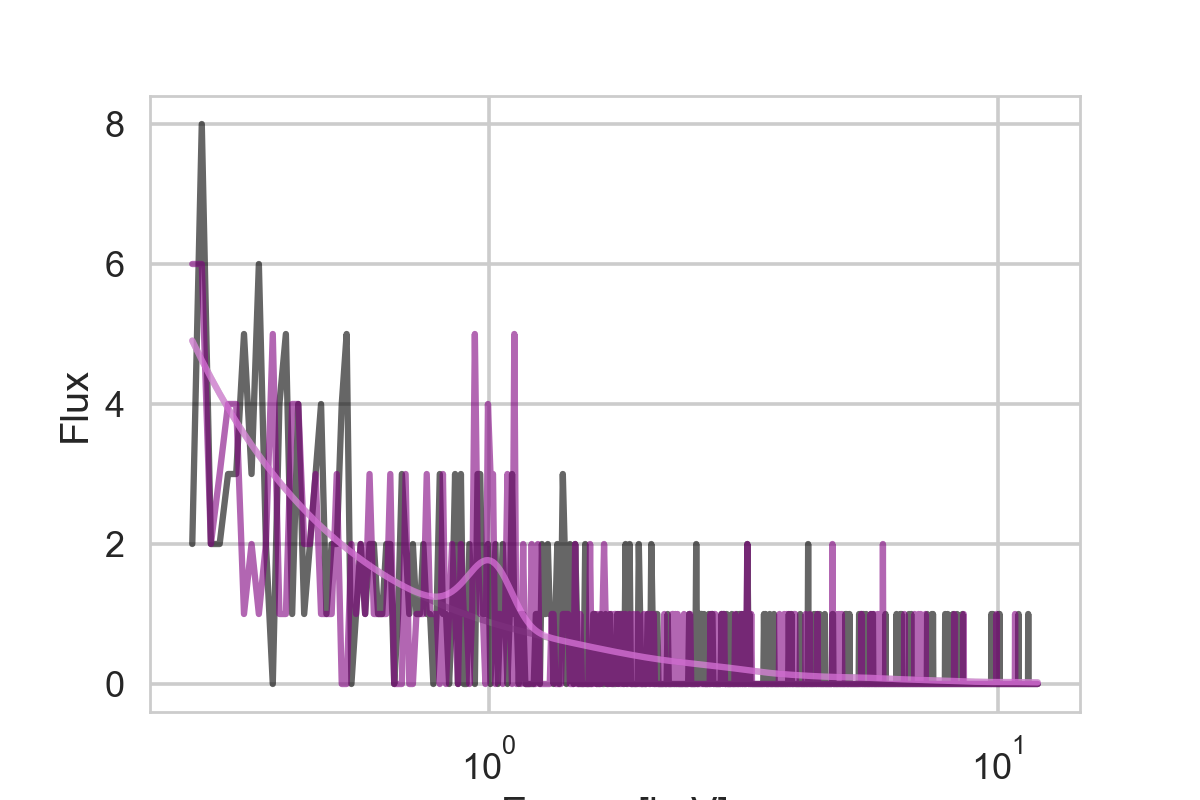

Text(0,0.5,'Flux')

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.semilogx(e_mid, bkg_data, alpha=0.6, color="black")
ax.semilogx(e_mid, bkg_model, alpha=0.6, color="grey")

ax.semilogx(e_mid, source_data, alpha=0.6, color="purple")
ax.semilogx(e_mid, source_model, alpha=0.6, color="violet")


ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux")

We should also make a version that is folded through the responses:

In [216]:
bkg_model

array([4.90537199, 4.62713032, 4.37578099, ..., 0.02293427, 0.02281819,
       0.02269859])

In [217]:
arf.exposure=1.0

In [218]:
bkg_arf = arf.apply_arf(bkg_model)
bkg_rmf = rmf.apply_rmf(bkg_arf)

source_arf = arf.apply_arf(source_model)
source_rmf = rmf.apply_rmf(source_arf)

bkg_counts = np.random.poisson(bkg_rmf)
source_counts = np.random.poisson(source_rmf)

<IPython.core.display.Javascript object>


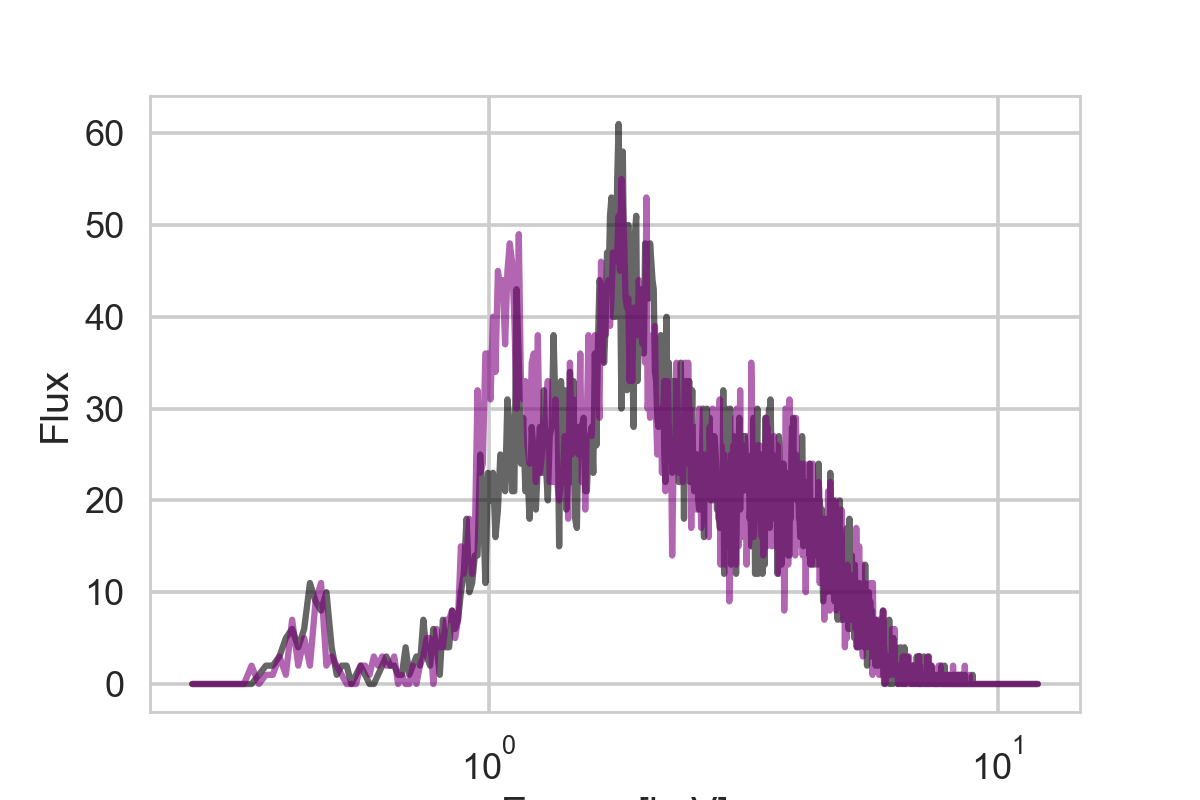

Text(0,0.5,'Flux')

In [219]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.semilogx(e_mid, bkg_counts, alpha=0.6, color="black")

ax.semilogx(e_mid, source_counts, alpha=0.6, color="purple")


ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux")

## Building a Model

Let's try to build a model to fit this:

In [161]:
class PoissonPosterior(object):
    
    def __init__(self, x, y, n_gauss, model=None, width_factor=0.4,
                 arf=None, rmf=None, xmax=None, apply_response=True):
        """
        Poisson Posterior for a single 1D X-ray spectrum.
        The spectrum can be modelled as a combination of a 
        set of Gaussian basis functions plus another parametric 
        model. It is also possible to *only* use a parametric model
        (when `n_gauss == 0`) or *only* use the a combination of 
        Gaussians (if `model == None`). 
        
        `arf` and `rmf` are expected to be instances of the respective
        Clarsach classes. If they are set to None, no responses will be 
        applied to the model before calculating the log-likelihood.
        
        Parameters
        -----------
        x, y: numpy.ndarrays
            The energies and counts of the observed spectrum
        
        n_gauss : int
            The number of polynomial terms (excluding the intercept)
        
        width_factor : float, optional, default 0.4
            The width factor for the Gaussan basis functions.
            Should probably be a fit parameter?
        
        model : `astropy.modeling.models` instance or `None`
            An astropy model. If set to `None`, only the 
            polynomial model will be calculated
            
        include_bias : bool, default: True
            boolean flag to decide whether to set an intercept
            weight (the x^0 term)
        
        arf, rmf: clarsach.ARF and clarsach.RMF instances
            The responses for the spectrum in `x` and `y`, 
            used to convert the source spectrum into the counts 
            observed by the detector.
            
        xmax: float
            The maximum energy to consider. Useful when only part 
            of the spectrum is of interest.
        
        Attributes
        ----------
        p : scipy.PolynomialFeatures instance
            sets the polynomial terms
            
        pft : (n_gauss, N) numpy.ndarray
        
        """
        
        if n_gauss == 0 and model is None:
            raise AttributeError("Either n_gauss must be non-zero or another model must be set!")
        
        self.x = x
        self.y = y
        
        self.arf = arf
        self.rmf = rmf
        
        self.n_gauss = n_gauss
        self.model = model
        self.xmax = xmax
        self.width_factor = width_factor
        self.apply_response = apply_response
        
        if self.xmax is not None:
            self.max_ind = self.x.searchsorted(self.xmax)
        else:
            self.max_ind = np.max(self.x.shape)+1
        
        if self.n_gauss > 0:
            # compute polynomial terms
            self._compute_gauss()
            
        if self.model is not None:
            self.npar = 0
            for pname in self.model.param_names:
                if not self.model.fixed[pname]:
                    self.npar += 1

        
    def _compute_gauss(self):
        self.p = GaussianFeatures(N=self.n_gauss, width_factor=self.width_factor)

        self.pft = self.p.fit_transform(self.x[:, np.newaxis])
        
        return
    
    def _apply_response(self, mean_model):
        """
        If any responses are given, apply them 
        to the model.
        """
        if self.arf is None and self.rmf is None:
            return mean_model
        
        else:
            model_arf = self.arf.apply_arf(mean_model)
            model_rmf = self.rmf.apply_rmf(model_arf)
            
            return model_rmf
        
    def _compute_mean_model(self, pars):
        # if no polynomial is used, initialize the mean 
        # model as a row of zeros
        if self.model is not None:
            _fitter_to_model_params(self.model, pars[-self.npar:])
            mean_model = self.model(self.x)
        
        else:
            mean_model = np.ones_like(self.x)
        
        if self.n_gauss > 0:
            # else get the weights vector out of the 
            # parameter vector and compute the polynomial
            
            # get the weights out of the parameter vector
            w = pars[:self.n_gauss]
            
            # compute polynomial mean model 
            mean_model *= np.dot(self.pft, w)
                        
        # if responses are given, apply them before 
        # calculating the likelihood
        if self.apply_response:
            model_counts = self._apply_response(mean_model)
        else:
            model_counts = mean_model

        return model_counts
    
    def logprior(self, pars):
        if (np.any(pars) < -10000) or (np.any(pars) > 10000):
            return -np.inf
        
        else:
            return 0.0

    def loglikelihood(self, pars, neg=False):
        """
        Evaluate the Poisson likelihood for a set of parameters.
        
        Parameters
        ----------
        pars : iterable
            A set of parameters to evaluate. The first `n_poly`
            parameters are the weights for the Polynomials, 
            the rest correspond to the parameters in `model`
        
        neg : bool, default False
            If True, return the negative log-likelihood.
            Set this to True for doing optimization
            (where you'll need the negative log-likelihood)
        
        Returns
        -------
        llike : float
            The log-likelihood of the data given the model.
        
        """
        
        model_counts = self._compute_mean_model(pars)
        
        model_counts[model_counts == 0.0] = 1e-20 
        
        llike = -np.nansum(model_counts[:self.max_ind]) + \
                np.nansum(self.y[:self.max_ind]*np.log(model_counts[:self.max_ind])) - \
                np.nansum(scipy.special.gammaln(self.y[:self.max_ind] + 1))
    
        if not np.isfinite(llike):
            llike = -np.inf

        if neg:
            return -llike
        else:
            return llike
    
    def logposterior(self, pars, neg=False):
        
        lp = self.logprior(pars) + self.loglikelihood(pars, neg=False)
        
        if not np.isfinite(lp):
            lp = -np.inf

        if neg:
            return -lp
        else:
            return lp
        
    
    def __call__(self, pars, neg=False):
        return self.logposterior(pars, neg=neg)

In [226]:
lpost = PoissonPosterior(e_mid, bkg_data, 10, model=pl, arf=arf, 
                         rmf=rmf, width_factor=true_pars["width_factor"])

In [227]:
true_pars_list = np.hstack([true_pars["wtrue"], true_pars["pl_norm"], true_pars["pl_idx"]])

In [228]:
true_pars["wtrue"]

array([0.53753518, 0.85140206, 0.97295537, 0.76213459, 0.94719812,
       0.87713283, 0.83317695, 0.6394935 , 0.77157563, 0.83825022])

In [229]:
lpost(true_pars_list)

-10465.848566308427

In [230]:
test_pars = true_pars_list + np.random.normal(0, 0.1, size=len(true_pars_list))

In [231]:
lpost(test_pars)

-9262.324010424956

Now we can do optimization!

In [186]:
res = scipy.optimize.minimize(lpost, test_pars, args=(True), method="L-BFGS-B")

 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning:invalid value encountered in log


Let's take a look at the results:

In [193]:
lpost = PoissonPosterior(e_mid, bkg_data, ngaussian, model=pl, 
                         arf=arf, rmf=rmf, apply_response=True, width_factor=true_pars["width_factor"])

In [194]:
opt_model = lpost._compute_mean_model(res.x)

<IPython.core.display.Javascript object>


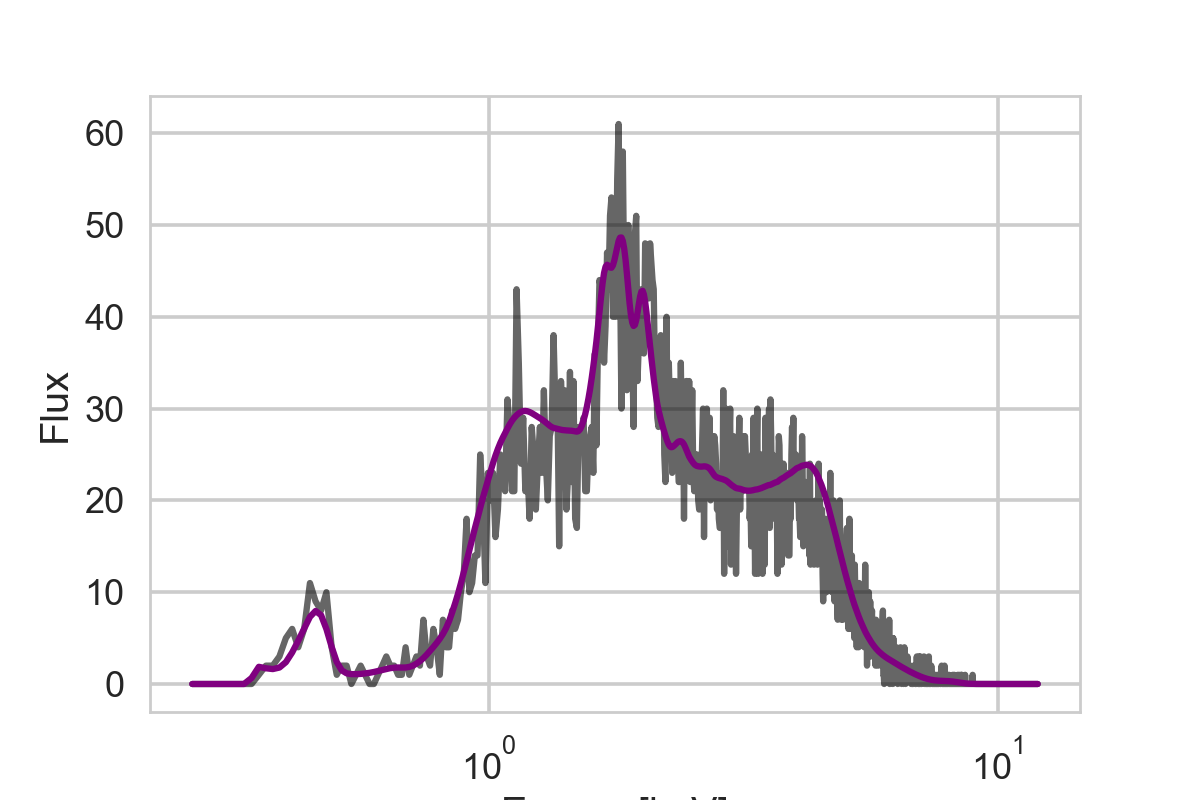

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.semilogx(e_mid, bkg_counts, alpha=0.6, color="black")

ax.semilogx(e_mid, opt_model, alpha=1.0, color="purple")


ax.set_xlabel("Energy [keV]")
ax.set_ylabel("Flux")
ax.set_xscale("log")

Okay, in the next step, I need to add the second spectrum with the extra line:

In [546]:
class TwoSpectrumPoissonPosterior(object):
    
    def __init__(self, n_gauss, x, ybkg, ysrc=None, bkg_model=None, src_model=None, 
                 width_factor=0.4, arf=None, rmf=None, 
                 xmax=None, apply_response=True):
        """
        Poisson Posterior for a single 1D X-ray spectrum.
        The spectrum can be modelled as a combination of a 
        set of Gaussian basis functions plus another parametric 
        model. It is also possible to *only* use a parametric model
        (when `n_gauss == 0`) or *only* use the a combination of 
        Gaussians (if `model == None`). 
        
        `arf` and `rmf` are expected to be instances of the respective
        Clarsach classes. If they are set to None, no responses will be 
        applied to the model before calculating the log-likelihood.
        
        Parameters
        -----------
        x : numpy.ndarray
            The energies of the observed spectrum

        n_gauss : int
            The number of polynomial terms (excluding the intercept)

        ybkg: numpy.ndarray
            The background spectrum

        ysrc: numpy.ndarray, optional
            The source spectrum
        
        width_factor : float, optional, default 0.4
            The width factor for the Gaussan basis functions.
            Should probably be a fit parameter?
        
        model : `astropy.modeling.models` instance or `None`
            An astropy model. If set to `None`, only the 
            polynomial model will be calculated
            
        width_factor : float
            The width factor for the Gaussian basis functions.
            Could possibly become a fitting parameter 
            in a future version?
        
        arf, rmf: clarsach.ARF and clarsach.RMF instances
            The responses for the spectrum in `x` and `y`, 
            used to convert the source spectrum into the counts 
            observed by the detector.
            
        xmax: float
            The maximum energy to consider. Useful when only part 
            of the spectrum is of interest.
            
        apply_arf : bool, optional, default True
            If False, don't apply the responses to the model spectrum.
            Useful for debuggung.
        
        Attributes
        ----------
        p : scipy.PolynomialFeatures instance
            sets the polynomial terms
            
        pft : (n_gauss, N) numpy.ndarray
        
        """
        
        if n_gauss == 0 and model is None:
            raise AttributeError("Either n_gauss must be non-zero or another model must be set!")
        
        self.x = x
        self.ybkg = ybkg
        self.ysrc = ysrc
        
        self.arf = arf
        self.rmf = rmf
        
        self.n_gauss = n_gauss
        self.bkg_model = bkg_model
        self.src_model = src_model
        
        self.xmax = xmax
        self.width_factor = width_factor
        self.apply_response = apply_response
        
        if self.xmax is not None:
            self.max_ind = self.x.searchsorted(self.xmax)
        else:
            self.max_ind = np.max(self.x.shape)+1
        
        if self.n_gauss > 0:
            # compute polynomial terms
            self._compute_gauss()

        self.bkg_npar = 0
        if self.bkg_model is not None:
            for pname in self.bkg_model.param_names:
                if not self.bkg_model.fixed[pname]:
                    self.bkg_npar += 1
                    
        self.src_npar = 0
        if self.src_model is not None:
            for pname in self.src_model.param_names:
                if not self.src_model.fixed[pname]:
                    self.src_npar += 1
        
    def _compute_gauss(self):
        self.p = GaussianFeatures(N=self.n_gauss, width_factor=self.width_factor)

        self.pft = self.p.fit_transform(self.x[:, np.newaxis])
        
        return
    
    def _apply_response(self, bkg_model, source_model=None):
        """
        If any responses are given, apply them 
        to the model.
        """
        if self.arf is None and self.rmf is None:
            return bkg_model, source_model

        else:
            bkg_arf = self.arf.apply_arf(bkg_model)
            bkg_rmf = self.rmf.apply_rmf(bkg_arf)
            
            if source_model is not None:
                source_arf = self.arf.apply_arf(source_model)
                source_rmf = self.rmf.apply_rmf(source_arf)
            
                return bkg_rmf, source_rmf
            else:
                return bkg_rmf, None
                
        
    def _compute_mean_model(self, pars):
        # if no polynomial is used, initialize the mean 
        # model as a row of zeros
        if self.bkg_model is not None:
            # background model parameters are the second-to-last few in the list:
            if self.src_model is not None:
                bkg_pars = pars[-self.bkg_npar-self.src_npar:-self.src_npar]
            else:
                bkg_pars = pars[-self.bkg_npar-self.src_npar:]
            _fitter_to_model_params(self.bkg_model, bkg_pars)
            mean_model = self.bkg_model(self.x)
        
        else:
            mean_model = np.ones_like(self.x)
        
        if self.n_gauss > 0:
            # else get the weights vector out of the 
            # parameter vector and compute the polynomial
            
            # get the weights out of the parameter vector
            w = pars[:self.n_gauss]
            
            # compute polynomial mean model 
            mean_model *= np.dot(self.pft, w)
            
        if self.src_model is not None:
            # background model parameters are the second-to-last few in the list:
            src_pars = pars[-self.src_npar:]
            _fitter_to_model_params(self.src_model, src_pars)
            source_model = self.src_model(self.x) + mean_model
        
        else:
            source_model = None

        # if responses are given, apply them before 
        # calculating the likelihood
        if self.apply_response:
            bkg_counts, source_counts = self._apply_response(mean_model, source_model)
        else:
            bkg_counts = mean_model
            source_counts =  source_model
            
        return bkg_counts, source_counts
    
    def logprior(self, pars):
        if (np.any(pars) < -10000) or (np.any(pars) > 10000):
            return -np.inf
        
        else:
            return 0.0

    def loglikelihood(self, pars, neg=False):
        """
        Evaluate the Poisson likelihood for a set of parameters.
        
        Parameters
        ----------
        pars : iterable
            A set of parameters to evaluate. The first `n_poly`
            parameters are the weights for the Polynomials, 
            the rest correspond to the parameters in `model`
        
        neg : bool, default False
            If True, return the negative log-likelihood.
            Set this to True for doing optimization
            (where you'll need the negative log-likelihood)
        
        Returns
        -------
        llike : float
            The log-likelihood of the data given the model.
        
        """
        
        bkg_counts, source_counts = self._compute_mean_model(pars)

        bkg_counts[bkg_counts == 0.0] = 1e-20 

        llike = -np.nansum(bkg_counts[:self.max_ind]) + \
                np.nansum(self.ybkg[:self.max_ind]*np.log(bkg_counts[:self.max_ind])) - \
                np.nansum(scipy.special.gammaln(self.ybkg[:self.max_ind] + 1))
        
        if self.ysrc is not None:
            source_counts[source_counts == 0.0] = 1e-20 

            llike += -np.nansum(source_counts[:self.max_ind]) + \
                    np.nansum(self.ysrc[:self.max_ind]*np.log(source_counts[:self.max_ind])) - \
                    np.nansum(scipy.special.gammaln(self.ysrc[:self.max_ind] + 1))
    
    
        if not np.isfinite(llike):
            llike = -np.inf

        if neg:
            return -llike
        else:
            return llike
    
    def logposterior(self, pars, neg=False):
        
        lp = self.logprior(pars) + self.loglikelihood(pars, neg=False)
        
        if not np.isfinite(lp):
            lp = -np.inf

        if neg:
            return -lp
        else:
            return lp

    def calculate_aic(self, pars):
        """
        Calculate the Akaike Information Criterion.
        """
        loglike = self.loglikelihood(pars, neg=False)
        aic = 2.*len(pars) - 2.*loglike
        return aic
    
    def calculate_bic(self, pars):
        """
        Calculate the Bayesian Information Criterion
        """
        loglike = self.loglikelihood(pars, neg=False)
        bic = np.log(self.x.shape[0])*len(pars) - 2.*loglike
        return bic

    def __call__(self, pars, neg=False):
        return self.logposterior(pars, neg=neg)

Awesome, let's try it!

In [547]:
lpost = TwoSpectrumPoissonPosterior(ngaussian, e_mid, bkg_counts, source_counts, 
                                    bkg_model=pl, src_model=gauss, 
                                    width_factor=true_pars["width_factor"], arf=arf, 
                                    rmf=rmf)

In [548]:
true_pars.keys()

dict_keys(['pl_idx', 'pl_norm', 'gauss_amp', 'gauss_mean', 'gauss_std', 'width_factor', 'wtrue'])

Below is a list of true parameters. It's useful to check that it at least computes a reasonable posterior for the true parameters:

In [549]:
true_pars_list = np.hstack([true_pars["wtrue"], true_pars["pl_norm"], true_pars["pl_idx"],
                           true_pars["gauss_amp"], true_pars["gauss_mean"], true_pars["gauss_std"]])

In [550]:
lpost(true_pars_list)

-3243.4786942519568

Let's perturb our true parameters to see whether we still get something reasonable a little bit away from the true parameters:

In [471]:
test_pars = true_pars_list + np.random.normal(0, 0.1, size=true_pars_list.shape[0])

In [472]:
test_pars[-3] = 0.5

In [473]:
lpost(test_pars)

-3299.4083589199

In [474]:
res = scipy.optimize.minimize(lpost, test_pars, args=(True), method="L-BFGS-B")

In [475]:
print(res)

      fun: 3244.914694270912
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([-14.42385837,  17.31241355,   4.3433829 , -24.89359758,
       -12.02533895,  21.65143087,   0.33032848,  -5.68616088,
        -6.69933797,   0.2750312 , -43.35743142, 156.2617399 ,
       -14.56937753,  43.21700544,  56.84960342])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 656
      nit: 23
   status: 0
  success: True
        x: array([0.51352795, 0.92152804, 1.02441717, 0.7420305 , 0.99843907,
       0.96603645, 0.82373167, 0.64337598, 0.67910572, 0.75177727,
       0.96114859, 1.49061309, 0.57450593, 0.98624638, 0.13494385])


In [476]:
opt_bkg_model, opt_src_model = lpost._compute_mean_model(res.x) 

<IPython.core.display.Javascript object>


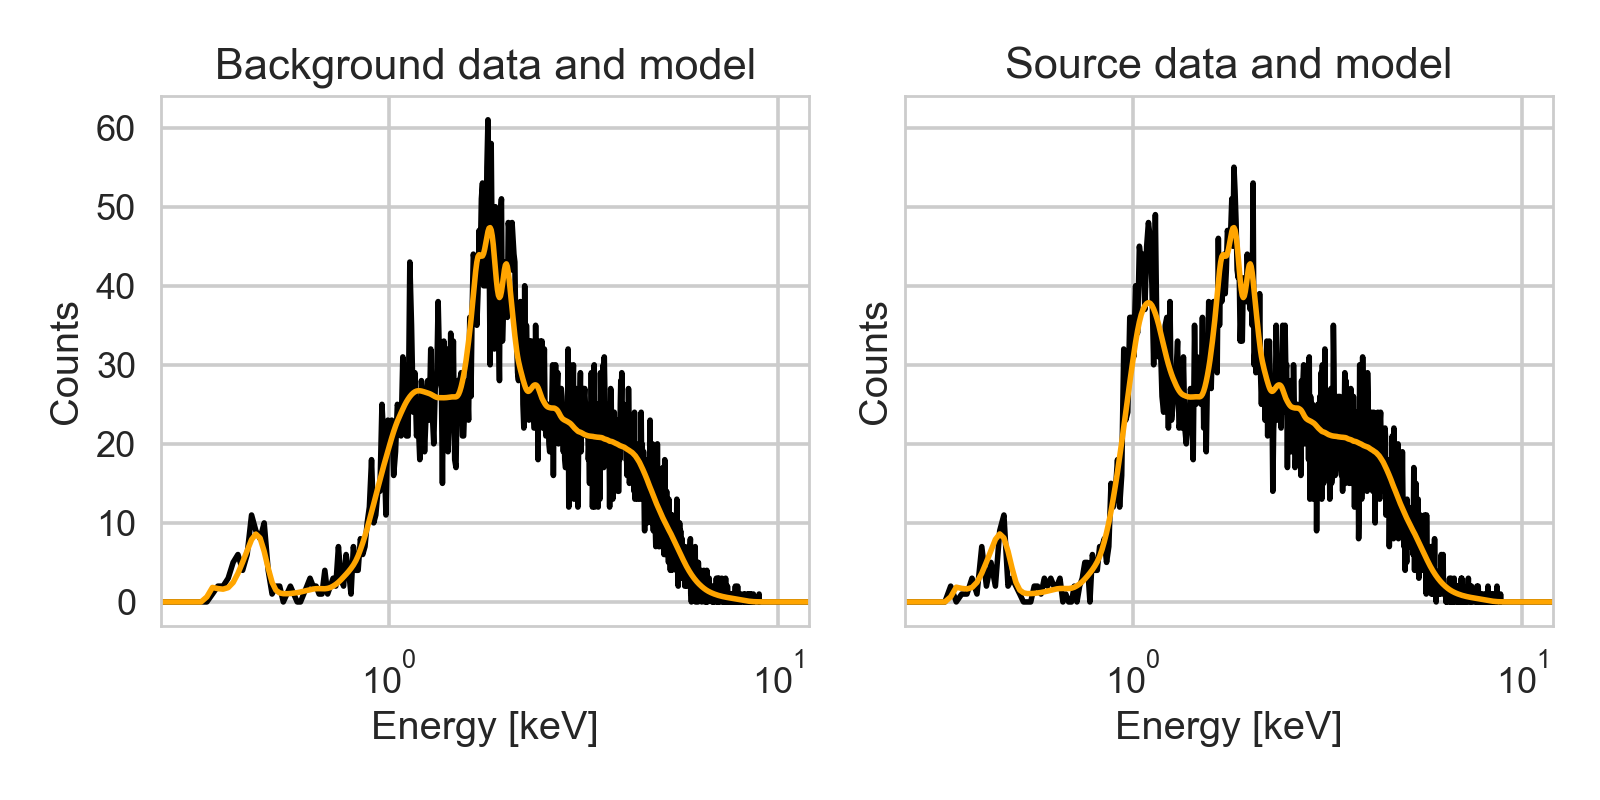

In [478]:
opt_bkg_model, opt_src_model = lpost._compute_mean_model(res.x) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

ax1.semilogx(e_mid, bkg_counts, lw=2, color="black", label="data")
ax1.plot(e_mid, opt_bkg_model, lw=2, color="orange", label="model")
ax1.set_xlim(e_mid[0], e_mid[-1])
ax1.set_xlabel("Energy [keV]")
ax1.set_ylabel("Counts")
ax1.set_title("Background data and model")

ax2.semilogx(e_mid, source_counts, lw=2, color="black")
ax2.plot(e_mid, opt_src_model, lw=2, color="orange", label="model")
ax2.set_xlim(e_mid[0], e_mid[-1])
ax2.set_xlabel("Energy [keV]")
ax2.set_ylabel("Counts")
ax2.set_title("Source data and model")

plt.tight_layout()


Can I fit just the background model with the current iteration?

In [417]:
lpost = TwoSpectrumPoissonPosterior(ngaussian, e_mid, bkg_counts, 
                                    bkg_model=pl,
                                    width_factor=true_pars["width_factor"], arf=arf, 
                                    rmf=rmf)

In [418]:
lpost(true_pars_list[:-2])

-8287.697483394142

In [419]:
lpost = TwoSpectrumPoissonPosterior(ngaussian, e_mid, bkg_counts, 
                                    bkg_model=pl,
                                    width_factor=true_pars["width_factor"], arf=arf, 
                                    rmf=rmf)

res_bkg = scipy.optimize.minimize(lpost, test_pars[:-2], args=(True), method="L-BFGS-B")

In [420]:
opt_bkg_model, opt_src_model = lpost._compute_mean_model(res_bkg.x)

In [421]:
opt_bkg_model

array([0., 0., 0., ..., 0., 0., 0.])

<IPython.core.display.Javascript object>


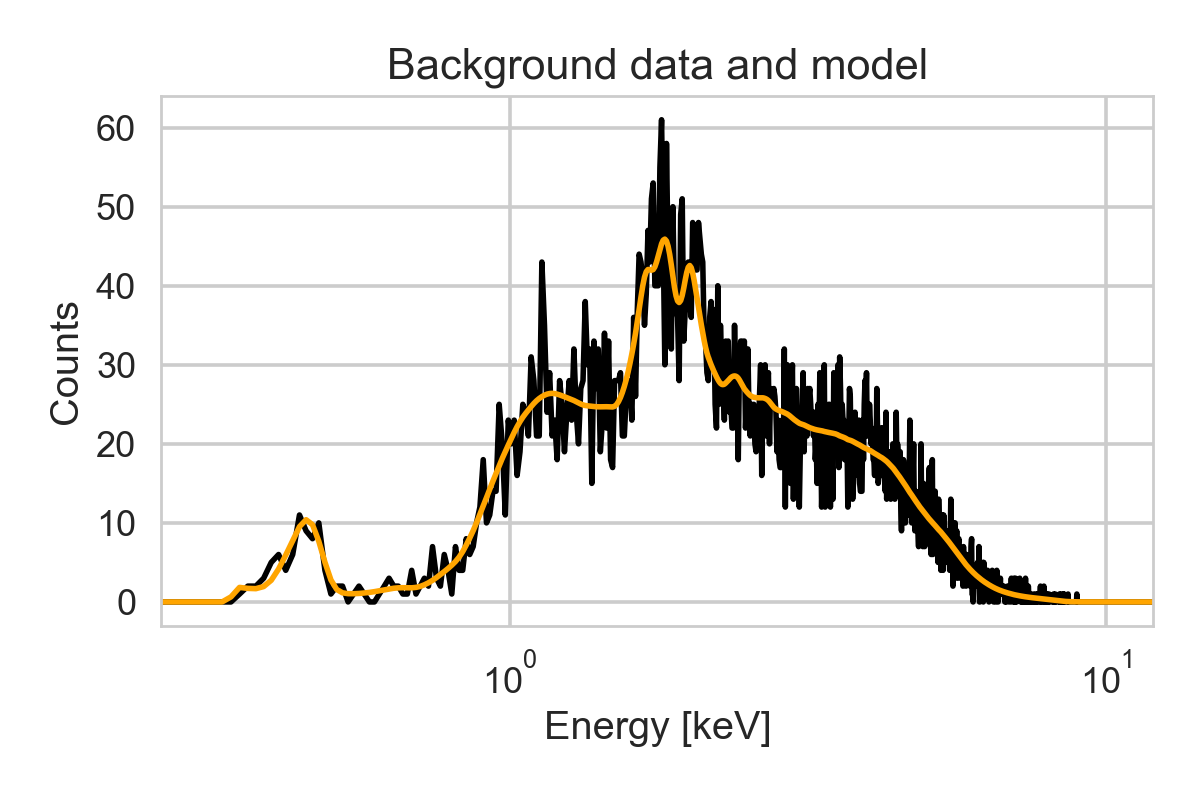

In [422]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,4))

ax1.semilogx(e_mid, bkg_counts, lw=2, color="black", label="data")
ax1.plot(e_mid, opt_bkg_model, lw=2, color="orange", label="model")
ax1.set_xlim(e_mid[0], e_mid[-1])
ax1.set_xlabel("Energy [keV]")
ax1.set_ylabel("Counts")
ax1.set_title("Background data and model")

plt.tight_layout()



Yay! That seems to work!

Now let's see if we can make it select the "best" number of Gaussians on just the background. We're going to use the Akaike and Bayesian Information Criteria for that:

In [487]:
ngaussians = np.arange(2, 50, 1, dtype=int)

In [517]:
rr

      fun: 1608.3917371670868
 hess_inv: <49x49 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.43983164,  -5.83168003,   8.26112228,  12.27563189,
         3.65980668,   0.59008016,  19.3118467 ,  30.96065484,
         0.87384251,  19.3111191 ,  15.51270543,   7.66522135,
        -6.20202627,  13.34847184,   9.46165528,   5.31363185,
         6.87577995,  34.8132744 ,  50.39182724,  -1.66801328,
       -11.0369001 , -15.70151653,  -2.9358489 ,  -4.79667506,
         3.20687832,  -4.4121407 ,  -3.00715328,   5.18921297,
         3.42406565,   4.00141289, -11.66699803,  -2.16896296,
        -7.97990651,  -4.74174158,  -8.11851351,  -3.70055204,
         4.66388883,   7.36690708,   5.83240762,   5.34273568,
         1.07902451,  -1.3038516 ,  -1.27256499,   0.22519089,
        -0.98734745,  -0.3441528 ,   0.22046152, 118.59228835,
       -32.75781637])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4250
      nit: 51
   status: 0
  success: True
  

Sometimes this seems to go off into unreasonable regions of parameter space, so I'm adding a while loop in order to keep it in the right range of parameter space.

**Beware**: This while loop *only* works for the spectrum set up here, because I vaguely know what the right value of the likelihood is. Do *not* attempt to use this on any other problem!

In [529]:

aic_all, bic_all, res_all = [], [], []

for ng in ngaussians:
    rr_func = -1e11
    while (rr_func < -1e4) or (rr_func > 1e4):
        print("Number of Gaussians: " + str(ng))
        lpost = TwoSpectrumPoissonPosterior(ng, e_mid, bkg_counts, 
                                        bkg_model=pl,
                                        width_factor=true_pars["width_factor"], arf=arf, 
                                        rmf=rmf)

        #if ng <= 10:
        #    wt = true_pars["wtrue"][:ng]
        #else:
        #wt = np.hstack([true_pars["wtrue"], 
        #                np.random.normal(loc=0.8, 
        #                                 scale=0.15, 
        #                                 size=ng-10)])

        wt = np.random.normal(loc=0.7, scale=0.15, size=ng)

        test_pars = np.hstack([wt, true_pars["pl_norm"], true_pars["pl_idx"]])

        test_pars += np.random.normal(0, 0.1, size=test_pars.shape[0])

        rr = scipy.optimize.minimize(lpost, test_pars[:-2], args=(True), method="L-BFGS-B")
        print(rr.message)
        print(str(rr.fun) + "\n")
        rr_func = rr.fun

    aic_all.append(lpost.calculate_aic(rr.x))
    bic_all.append(lpost.calculate_bic(rr.x))
    res_all.append(rr)

Number of Gaussians: 2


 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:212: RuntimeWarning:invalid value encountered in log


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1664.1707965041896

Number of Gaussians: 3
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1641.7175414835401

Number of Gaussians: 4
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1647.1682022199093

Number of Gaussians: 5
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1649.3660627717181

Number of Gaussians: 6
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1652.125891310814

Number of Gaussians: 7
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1632.6591995433955

Number of Gaussians: 8


 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning:overflow encountered in power
 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning:overflow encountered in multiply


b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
21420.147660043174

Number of Gaussians: 8


 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/clarsach-0.0.0-py3.6.egg/clarsach/respond.py:248: RuntimeWarning:invalid value encountered in add


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
-7252237.807098023

Number of Gaussians: 8


 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning:invalid value encountered in reduce
 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:212: RuntimeWarning:invalid value encountered in multiply


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
-319735.52195123053

Number of Gaussians: 8
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1631.6284196832494

Number of Gaussians: 9
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1645.177004126941

Number of Gaussians: 10
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1637.2957855241475

Number of Gaussians: 11
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1619.0069329448197

Number of Gaussians: 12
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1636.7801643739476

Number of Gaussians: 13
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1618.371395721504

Number of Gaussians: 14
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1625.1747597055255

Number of Gaussians: 15
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
-18097491.720985048

Number of Gaussians: 15


 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning:overflow encountered in multiply
 /opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/clarsach-0.0.0-py3.6.egg/clarsach/respond.py:336: RuntimeWarning:overflow encountered in multiply


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
-2.2841770684241923e+118

Number of Gaussians: 15
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1621.3692653137878

Number of Gaussians: 16
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1617.4199018746076

Number of Gaussians: 17
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1633.7059771318309

Number of Gaussians: 18
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1659.9597798173309

Number of Gaussians: 19
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
-1.3327864463671132e+23

Number of Gaussians: 19
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1621.5551919259924

Number of Gaussians: 20
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1627.7341843198956

Number of Gaussians: 21
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1620.0754938866921

Number of Gaussians: 22
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
1619.467182159271

Number of Gaussians: 23
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FAC

Let's plot the AIC and BIC curves as a function of the number of Gaussians:

<IPython.core.display.Javascript object>


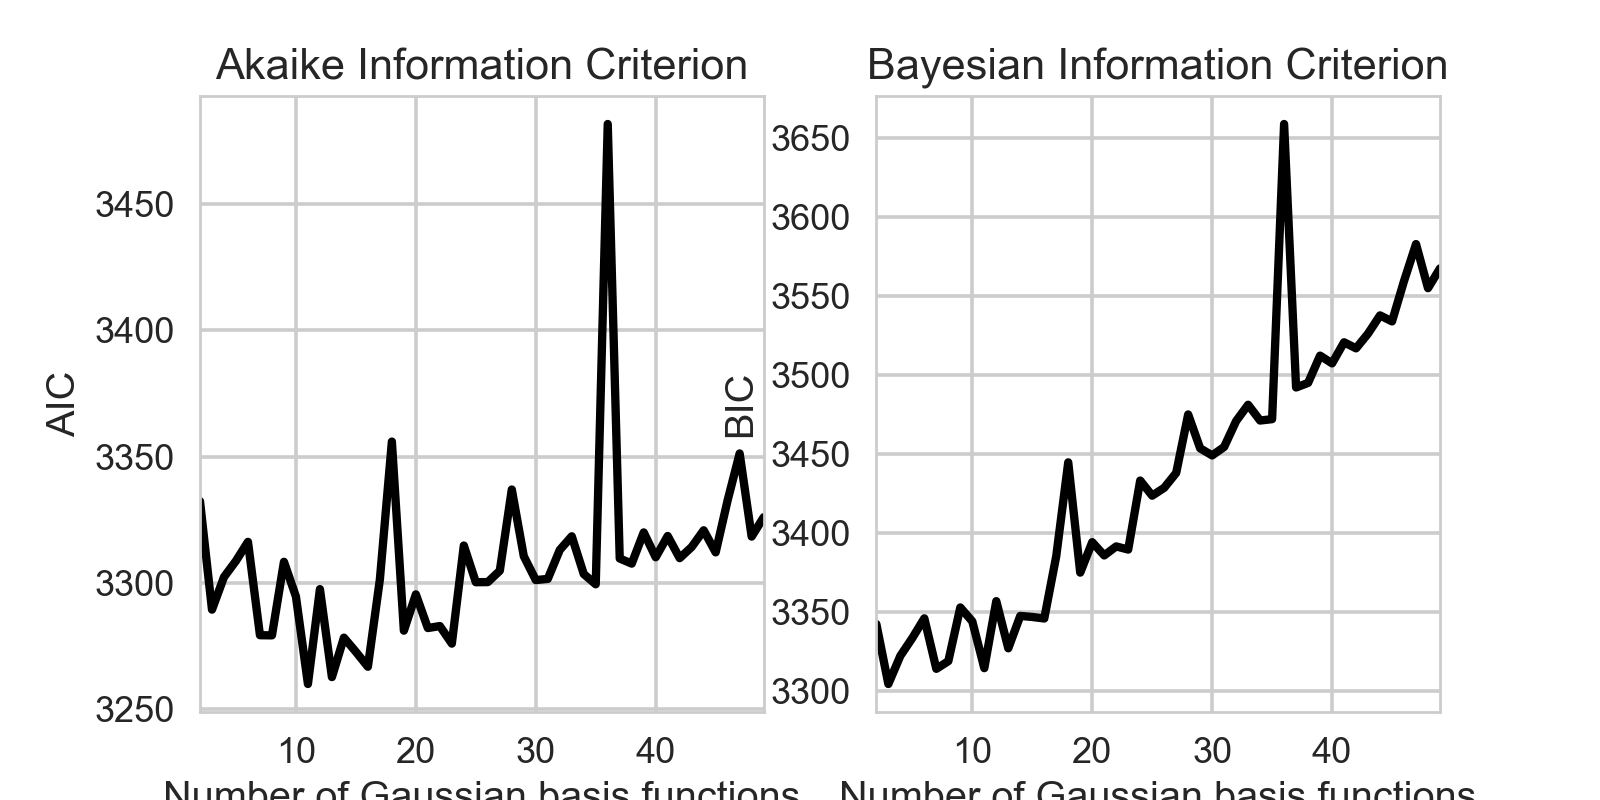

Text(0.5,1,'Bayesian Information Criterion')

In [530]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(ngaussians, aic_all, lw=3, color="black")
ax1.set_xlim(np.min(ngaussians), np.max(ngaussians))
ax1.set_xlabel("Number of Gaussian basis functions")
ax1.set_ylabel("AIC")
ax1.set_title("Akaike Information Criterion")
#ax1.set_yscale('log')

ax2.plot(ngaussians, bic_all, lw=3, color="black")
ax2.set_xlim(np.min(ngaussians), np.max(ngaussians))
#ax2.set_yscale("log")
ax2.set_xlabel("Number of Gaussian basis functions")
ax2.set_ylabel("BIC")
ax2.set_title("Bayesian Information Criterion")



Ok, cool, let's take a look at the 11 basis function model, since it seemst to work overall the best (where "best" is at least somewhat determined by how well the individual optimizations work, so should be taken with a grain of salt), and compare it to the 13 basis function model, which comes in at a close second:

In [534]:
from matplotlib import gridspec

<IPython.core.display.Javascript object>


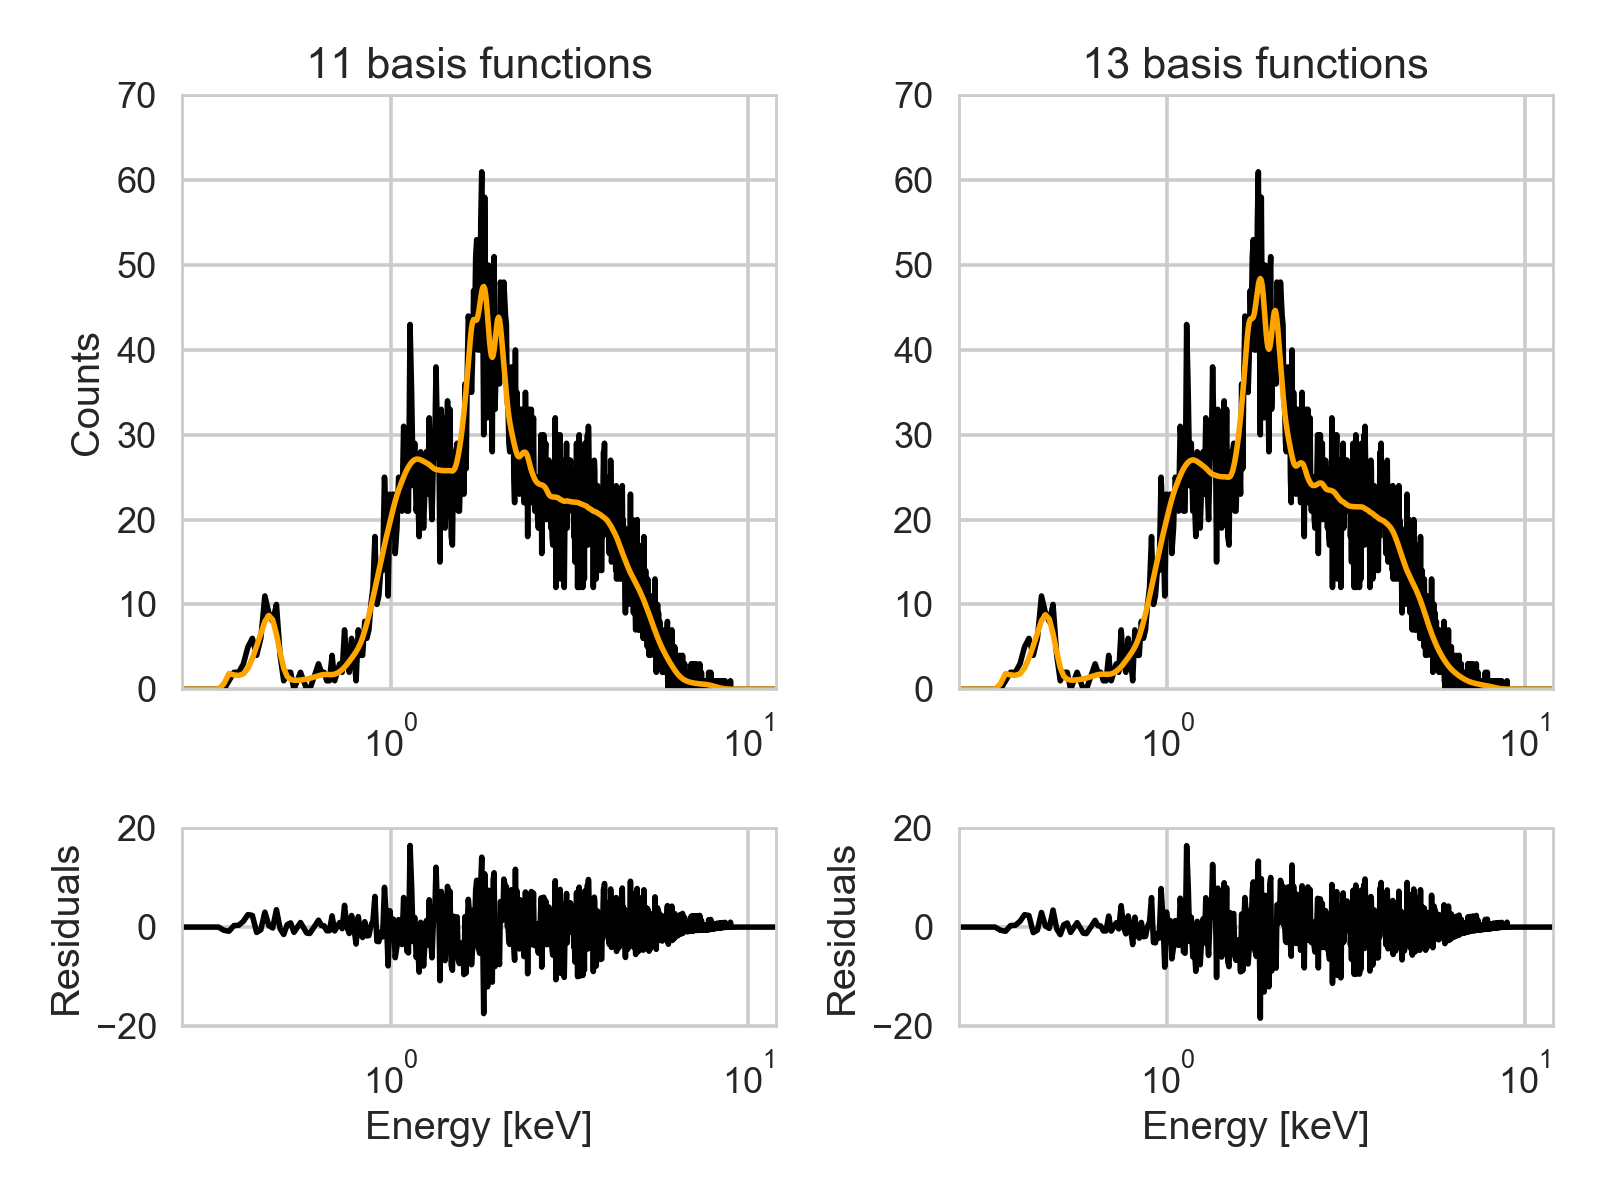

In [541]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)
fig = plt.figure(figsize=(8, 6)) 

gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1]) 

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ng = 11
ind_tmp = ngaussians.searchsorted(ng)
lpost_tmp = TwoSpectrumPoissonPosterior(ng, e_mid, bkg_counts, 
                                bkg_model=pl,
                                width_factor=true_pars["width_factor"], arf=arf, 
                                rmf=rmf)

res_tmp = res_all[ind_tmp]
opt_bkg_model_tmp, _ = lpost_tmp._compute_mean_model(res_tmp.x)

ax1.semilogx(e_mid, bkg_counts, lw=2, color="black", label="data")
ax1.plot(e_mid, opt_bkg_model_tmp, lw=2, color="orange", label="model")
ax1.set_xlim(e_mid[0], e_mid[-1])
ax1.set_ylim(0, 70)
ax1.set_ylabel("Counts")
ax1.set_title("%i basis functions"%ng)


ax3.semilogx(e_mid, bkg_counts-opt_bkg_model_tmp, lw=2, color="black", label="residuals")
ax3.set_xlim(e_mid[0], e_mid[-1])
ax3.set_xlabel("Energy [keV]")
ax3.set_ylabel("Residuals")
ax3.set_ylim(-20, 20)

ng = 13
ind_tmp = ngaussians.searchsorted(ng)
lpost_tmp = TwoSpectrumPoissonPosterior(ng, e_mid, bkg_counts, 
                                bkg_model=pl,
                                width_factor=true_pars["width_factor"], arf=arf, 
                                rmf=rmf)

res_tmp = res_all[ind_tmp]
opt_bkg_model_tmp, _ = lpost_tmp._compute_mean_model(res_tmp.x)

ax2.semilogx(e_mid, bkg_counts, lw=2, color="black", label="data")
ax2.plot(e_mid, opt_bkg_model_tmp, lw=2, color="orange", label="model")
ax2.set_xlim(e_mid[0], e_mid[-1])
ax2.set_ylim(0, 70)
ax2.set_title("%i basis functions"%ng)


ax4.semilogx(e_mid, bkg_counts-opt_bkg_model_tmp, lw=2, color="black", label="residuals")
ax4.set_xlim(e_mid[0], e_mid[-1])
ax4.set_xlabel("Energy [keV]")
ax4.set_ylabel("Residuals")
ax4.set_ylim(-20, 20)

plt.tight_layout()




All right! Let's now take the model with 11 basis functions and apply it to the source and the background spectrum simultaneously:

In [619]:
ng = 11

lpost = TwoSpectrumPoissonPosterior(ngaussian, e_mid, bkg_counts, source_counts, 
                                    bkg_model=pl, src_model=gauss, 
                                    width_factor=true_pars["width_factor"], arf=arf, 
                                    rmf=rmf)
wt = np.random.normal(loc=0.7, scale=0.15, size=ng)

test_pars = np.hstack([wt, true_pars["pl_norm"], true_pars["pl_idx"], 
                       true_pars["gauss_amp"], true_pars["gauss_mean"], true_pars["gauss_std"]])

test_pars += np.random.normal(0, 0.1, size=test_pars.shape[0])

res = scipy.optimize.minimize(lpost, test_pars, args=(True), method="L-BFGS-B")

In [620]:
res.fun

3242.6528144838994

In [621]:
res.message

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

What's the fractional difference between the true parameters and the best-fit parameters:

In [622]:
np.abs(true_pars_list[-5:] - res.x[-5:])/true_pars_list[-5:]

array([0.08461735, 0.09444397, 0.17851559, 0.00453528, 0.04079666])

Let's take a look at what that actually looks like:

<IPython.core.display.Javascript object>


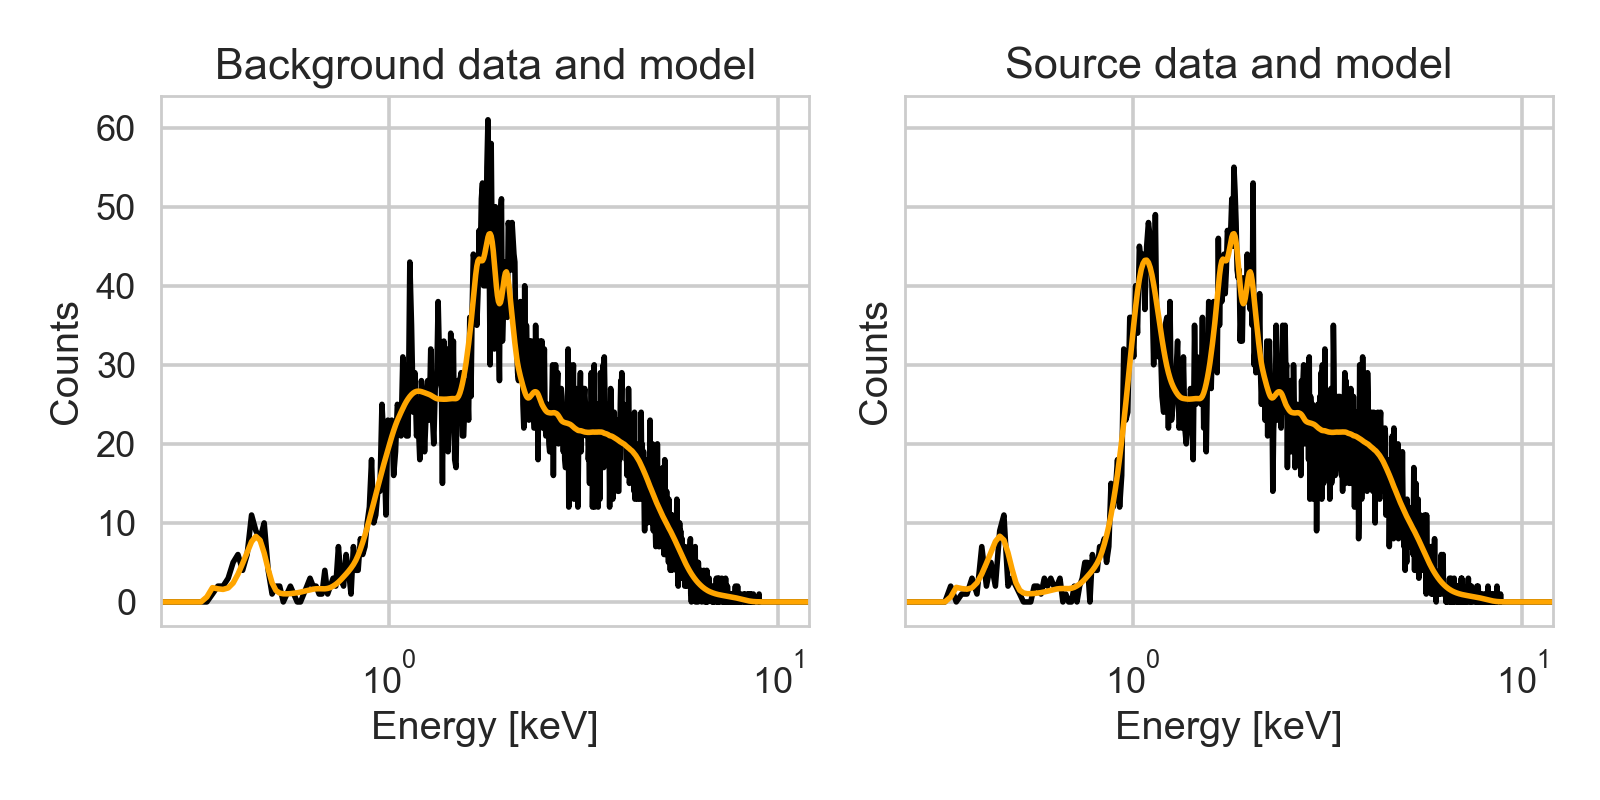

In [623]:
opt_bkg_model, opt_src_model = lpost._compute_mean_model(res.x) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharey=True)

ax1.semilogx(e_mid, bkg_counts, lw=2, color="black", label="data")
ax1.plot(e_mid, opt_bkg_model, lw=2, color="orange", label="model")
ax1.set_xlim(e_mid[0], e_mid[-1])
ax1.set_xlabel("Energy [keV]")
ax1.set_ylabel("Counts")
ax1.set_title("Background data and model")

ax2.semilogx(e_mid, source_counts, lw=2, color="black")
ax2.plot(e_mid, opt_src_model, lw=2, color="orange", label="model")
ax2.set_xlim(e_mid[0], e_mid[-1])
ax2.set_xlabel("Energy [keV]")
ax2.set_ylabel("Counts")
ax2.set_title("Source data and model")

plt.tight_layout()



##### Notes

* This might work better with gradients implemented, but I'm not sure how
* The width parameter is currently set by hand, which might require some fiddling
* The likelihood function is currently really slow because the application of responses to the model in `_compute_mean_model` is *really* slow (~a few tens of milliseconds for the Chandra/ACIS responses I used here). It might be worth figuring out how to apply responses to parts of spectra, which should cut down the computation time *significantly*. That's beyond my current understanding of how X-ray responses work.